In [39]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer,Dropout
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight

In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')
images_directory = path/'train_images'

In [11]:
cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64), subset='training', validation_split=.2, seed=10)
cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64), subset='validation', validation_split=.2, seed=10)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


# summary so far
## Overfitting 
So, we're grossly overfitting. That is a problem.   
The false negatives for validation are going up, and recall is going down, continuously.  
## What that means for our problem
For our problem, the false negatives and recall are most important- missing a whale means we might hurt it - since there are only 400 of them in the world, thats a massive problem.  
On the other hand, a false positive means ships in the area slow down without a whale being present. This is still pretty important - too many, and shipping will complain, or ignore requests to slow down. 

## What to do next 
There are 2 pathways I could take - 1 is to start optimizing.  
But since I know CNN wont be our final model, I think thats too early. Most literature I've read uses transfer learning - its easier to start with a good baseline. So lets try that, and optimize from there. 

## Literature Review
I've reviewed both blog posts, and papers regarding how to proceed, and whether transfer learning is helpful.  
Most of the blog posts appear to create a CNN network without using transfer learning, however most don't describe their layer creation logic. 
## Layer Creation
https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ 
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw 
When choosing the number of layers, experimentation seems to be the most common approach, using existing work, and intuition, as well as literally brute forcing. I don't have the compute power to brute force, so lets go with utilizing transfer learning

In [5]:
print("Hello World!")

Hello World!


# Transfer Learning 
## Papers
### Rethinking CNN for Sounds 
Rethinking CNN Models for Audio Classification https://arxiv.org/pdf/2007.11154.pdf
Comparison of Pre-Trained CNNs for Audio Classification Using Transfer Learning 
https://doi.org/10.3390/jsan10040072

It looks like VGG has an excellect accuracy on various urban sounds datasets, and that transfer learning from ImageNet tends to work better than from scratch training. 


### Grouper Sound

"Transfer learning for efficient classification of grouper sound" https://doi.org/10.1121/10.0001943 compared various transfer learning techniques for classifying underwater grouper sounds - the fish make specific sounds during spawning aggregations.   
The paper compared various network models on multiple types of groupers, as well as comparing spectograms with scalograms and finding both performed similarly.
Since this is underwater sound recognition, its quite similar to our problem. 

### Rainforest Animal Sounds 
"Classification of animal sounds in a hyperdiverse rainforest using Convolutional Neural Networks"  
I found this paper incredibly helpful for data augmentation discussion, since visual representations of sounds are limited in how they can be augmented (before the picture represents a completely different sound). Also very helpful for experimentation on techniques. Very guiding! 

### Predicting Using Unbalanced Classes
Our right whale to non- right whale (which we call no whale in code) sounds is about 1 to 5, so the class is a bit unbalanced. 
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data 
https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99 
I could balance the data using augmentation, but that would explode my dataset from 30K to amost 55K, which is a lot of images. Since I would like to use transfer learning to help with efficiency, I dont want to process on almost 2x data. It seems like class weights from tensorflow is a viable solution - adding attention to the whale class. 
 
### Cat Sounds 
CNN with Million song dataset- here, they are using a CNN to do feature extraction from cat sounds, and then actually running on classical classifiers on the features - Trees, LDA, Ensemble. The authors compare using a CNN with CDBN, and find them comparable, although it appears CDBN works slightly better. I like the slightly different approach to this problem. 

### Comparison 
https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96 


## Steps 
Since both rainforest and grouper sounds aggregate that VGG19 trained on ImageNet performs well, I think I'd like to start there. Additionally I like the idea of reducing training time, I only have a little laptop after all 

1. Lets try 
2. Class weights - I guessed previously, now lets actually get the right weights
3. The shape of the data. VGG19 expects 244 by 244 by default, and Im still operating on 64 by 64. To clean up and for consistenly, lets get it to 244


# Fix Input 
1. Copy original work from Notebook 2 
2. Adjust the size of the graph
3. Recreate(and overwrite) the existing spectrograms 

The original size was .72 inches, w/ a dpi of 400, 
400*.72 = 288
I need 224, so adjust to .56


In [92]:
def read_sound(index, df):
    row = df.iloc[index]
    clip_path = row['clip_path']
    image_path = row['image_path']
    y, sr = librosa.load(clip_path, sr=None)
    del clip_path, row
    return y, sr, image_path 

def create_spectrogram(input_tuple):
    y, sr, output_file = input_tuple
    fig = plt.figure(figsize=[0.56, 0.56])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))
    plt.savefig(output_file, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del spec, fig, ax, y, sr, output_file, input_tuple
    

In [24]:
for i in tqdm(range(0, answers.shape[0])):
    create_spectrogram(read_sound(i, answers))

100%|█████████████████████████████████████| 30000/30000 [31:22<00:00, 15.94it/s]


In [89]:
cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64), subset='training', validation_split=.2, seed=10)
cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64), subset='validation', validation_split=.2, seed=10)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


In [ ]:
keras.backend.clear_session()

# Model 1 

## Bunches of Metrics

In [16]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


## Class Weight Computation

In [19]:

xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
class_weight = dict(zip(np.unique(answers.label), xx))

## Model VGG19 Transfer Learning 1

In [90]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

#Which should I try? 
# I liked the Jungle approach - they set up a custom function to do this - but for my first try, lets just take their patterns
x = Dense(100, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.3)(x)   
predictions = Dense(1, activation='softmax')(x)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [91]:
history = model.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight)

Epoch 1/10
 47/750 [>.............................] - ETA: 3:05 - loss: 2.2916 - tp: 1035.0000 - fp: 3285.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2396 - precision: 0.2396 - recall: 1.0000 - auc: 0.5000 - prc: 0.2396

KeyboardInterrupt: 

# Discussion on Size
The size of the input severely limits how quickly I can train the model. However, my input is special - its not a true picture. Why would I make it so big, if the info in it can be put into smaller bits?  
The spectrogram is small, because the sample rate of the sound is only 2kHz,and the sounds are short.  
This means that I can summarize the entirety of the data into a much smaller size  
And limit my input size, therefore speeding up my model. We can always make it bigger, but lets try to make it smaller first. 

# So, the images 
The images are only 8 across, but theyre tall - that, however, can be transformed in Librosa using the nfft parameter 

## Starting by Copying the Librosa Investigation in Notebook 1

#So 128 produces a (65*126) whereas 256 produces a (129*63)
#Can we train on a non-square image? https://stats.stackexchange.com/questions/240690/non-square-images-for-image-classification 
Based on this - yes but its not lovely. 
nfft parameter of 192 produces a 97 by 84 image - can we crop it to make it square? 
## Can we drop some of the signal from the sides?
We would be dropping the vertical signal, which for this dataset sits between 0 and 1024. Since typical right whale characterizations falls below 1024, we can likely crop the images without concern. 

# Is this even allowed by VGG? Maaaybe?? Looks like generally a yes... 





(97, 84)


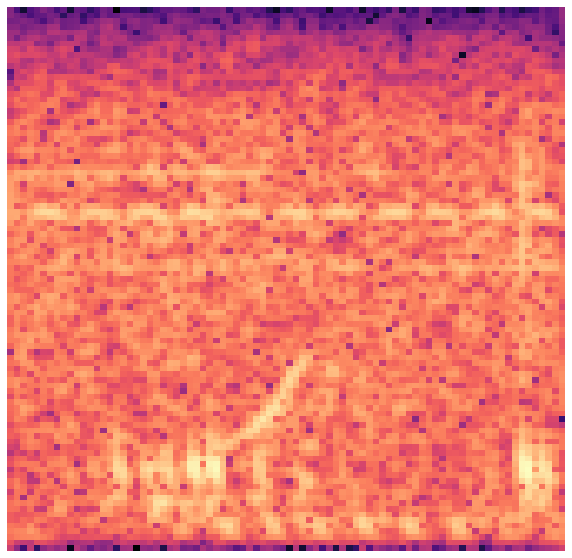

In [95]:
# mfccs = librosa.feature.mfcc(y=y, sr=sr)
which_file = 28
filename1 = f'''train{which_file}.aiff'''
filename1
y, sr = librosa.load('data/train/'+filename1,sr=None)



nfft=192
#So 128 produces a (65*126) whereas 256 produces a (129*63)
#Can we train on a non-square image? https://stats.stackexchange.com/questions/240690/non-square-images-for-image-classification 



Y0 = librosa.stft(y, n_fft=n_fft)
#Window length explanation: https://dsp.stackexchange.com/questions/248/how-do-i-optimize-the-window-lengths-in-stft 
#Since we care about the frequency more than the time, we should keep the window default 
print(Y0.shape)
Y = librosa.amplitude_to_db(Y0, ref=np.min )
#librosa.display.specshow(Y,sr=sr,x_axis='time', y_axis='mel',n_fft=n_fft)
#So generally, Melgrams - closer to the way we hear, perform better. However, these are whales, after all, underwater - will it actually perform better?? Or is what works for humans not ideal in this case? 
#Cat classificator uses mel spectrograms 
# https://en.wikipedia.org/wiki/Whale_vocalization 
#Right whales dont quite sing - they do an "upcall"
#So - humans hear on the melscale. Maybe whales dont. But - in order to visualize better, I want to see the spectrogram better for humans
#Same with amplitude
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)

spec = librosa.stft(y, n_fft=n_fft)
librosa.display.specshow(librosa.power_to_db(spec, ref=np.min),n_fft=n_fft)
plt.savefig('temp.png', dpi=97, bbox_inches='tight', pad_inches=0)
#Yep, all looks well 

# Do we have to Crop?  No
Using the Tropical Rainforest paper, it appears it is acceptable to stretch the image - just not flip or turn it. 

so stretching it is! 


# Once More, We create the Spectrograms
How Big? 

So: 97 by 97 



In [96]:
def read_sound(index, df, feature=True):
    row = df.iloc[index]
    clip_path = row['clip_path']
    if feature:
        image_path = row['image_path']
    else:
        image_path = row['image_path2']
    y, sr = librosa.load(clip_path, sr=None)
    del clip_path, row
    return y, sr, image_path, feature 

def create_spectrogram(input_tuple):
    y, sr, output_file,feature = input_tuple
    n_fft=192
    
    fig = plt.figure(figsize=[1, 1])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    if feature:
        spec = librosa.feature.melspectrogram(y=y, sr=sr)
    else:
         spec = librosa.stft(y, n_fft=n_fft)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.min),n_fft=n_fft)
    plt.savefig(output_file, dpi=97, bbox_inches='tight', pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del spec, fig, ax, y, sr, output_file, input_tuple
    

In [97]:
for i in tqdm(range(0, answers.shape[0])):
    create_spectrogram(read_sound(i, answers, feature=False))

100%|█████████████████████████████████████| 30000/30000 [31:52<00:00, 15.69it/s]


# Lets try the Model Again

In [99]:
cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='training', validation_split=.2, seed=10)
cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='validation', validation_split=.2, seed=10)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


In [100]:

xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
class_weight = dict(zip(np.unique(answers.label), xx))
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]




In [103]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

#Which should I try? 
# I liked the Jungle approach - they set up a custom function to do this - but for my first try, lets just take their patterns
x = Dense(100, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.3)(x)   
predictions = Dense(1, activation='softmax')(x)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)

In [104]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [105]:
history = model.fit(cb_training, epochs=100,validation_data=cb_validation, class_weight = class_weight)

Epoch 1/100
750/750 [==============================] - 738s 981ms/step - loss: 0.5774 - tp: 5628.0000 - fp: 18372.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2345 - precision: 0.2345 - recall: 1.0000 - auc: 0.5000 - prc: 0.2345 - val_loss: 0.3308 - val_tp: 1399.0000 - val_fp: 4601.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2332 - val_precision: 0.2332 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.2332
Epoch 2/100
750/750 [==============================] - 666s 888ms/step - loss: 0.3959 - tp: 5628.0000 - fp: 18372.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2345 - precision: 0.2345 - recall: 1.0000 - auc: 0.5000 - prc: 0.2345 - val_loss: 0.3476 - val_tp: 1399.0000 - val_fp: 4601.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2332 - val_precision: 0.2332 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.2332
Epoch 3/100
750/750 [==============================] - 653s 871ms/step - loss: 0.3655 - tp: 5628.0000 - fp: 18372.00

Epoch 38/100
750/750 [==============================] - 620s 826ms/step - loss: 0.2491 - tp: 5628.0000 - fp: 18372.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2345 - precision: 0.2345 - recall: 1.0000 - auc: 0.5000 - prc: 0.2345 - val_loss: 0.3685 - val_tp: 1399.0000 - val_fp: 4601.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2332 - val_precision: 0.2332 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.2332
Epoch 39/100
750/750 [==============================] - 621s 828ms/step - loss: 0.2490 - tp: 5628.0000 - fp: 18372.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2345 - precision: 0.2345 - recall: 1.0000 - auc: 0.5000 - prc: 0.2345 - val_loss: 0.3851 - val_tp: 1399.0000 - val_fp: 4601.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2332 - val_precision: 0.2332 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.2332
Epoch 40/100
750/750 [==============================] - 619s 825ms/step - loss: 0.2415 - tp: 5628.0000 - fp: 18372

Epoch 75/100
750/750 [==============================] - 638s 851ms/step - loss: 0.2145 - tp: 5628.0000 - fp: 18372.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2345 - precision: 0.2345 - recall: 1.0000 - auc: 0.5000 - prc: 0.2345 - val_loss: 0.5510 - val_tp: 1399.0000 - val_fp: 4601.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2332 - val_precision: 0.2332 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.2332
Epoch 76/100
750/750 [==============================] - 637s 849ms/step - loss: 0.2138 - tp: 5628.0000 - fp: 18372.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2345 - precision: 0.2345 - recall: 1.0000 - auc: 0.5000 - prc: 0.2345 - val_loss: 0.5789 - val_tp: 1399.0000 - val_fp: 4601.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2332 - val_precision: 0.2332 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.2332
Epoch 77/100
750/750 [==============================] - 638s 851ms/step - loss: 0.2189 - tp: 5628.0000 - fp: 18372

KeyboardInterrupt: 

# Review 
## Terrible Accuracy and Weirdness in the TN FN metrics

So the accuracy is terrible. Why?  
TN and FN are zero - why are they zero? What the heck? 
* I adjusted the input 
* I adjusted the class weights 
* We're not using a CNN after the transfer learning. 
* Transfer Learning - maybe this didnt actually help? 
* Did I make a mistake? (Spoiler: Yes)

## Checking What Happened 
We need to figure out why the accuracy dropped so much. So lets go back to the original CNN model with the new spectrograms, and rerun it. 
### Experiment 1: Run model w/ original class weights, but new spectrograms 
In notebook 3, we were getting .9 accuracy, even if we were overfitting grossly. If its the new spectrograms, then running that model w/ other parameters the same should drop the accuracy like a rock. 

### Experiment 2: The class Weights 
If the new spectrograms dont make the difference, then we also adjusted the class weights. Run the original model with the new class weights, and see if the accuracy drops.  

# See you in the Next Notebook